# Distance workflow

In [1]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import geopandas as gpd
from tkinter import filedialog
from tkinter import Tk, filedialog, Button, Label, simpledialog, messagebox
import rasterio
from rasterio.features import rasterize
import os
from shapely.geometry import LineString


Requires a 2D numpy array with zeros and ones as input

In [2]:
def calculate_distance(arr, max_distance=20, dtype=np.float32):
    """
    Calculate normalized distance from 1's in the input array.

    Args:
    arr (np.ndarray): Input binary array.
    max_distance (float): Maximum distance to consider (default: 20).
    dtype (np.dtype): Data type for the output array (default: np.float32).

    Returns:
    np.ndarray: Normalized distance array.
    """
    # Ensure input is a numpy array
    arr = np.asarray(arr, dtype=bool)

    # Calculate the distance transform
    dist = distance_transform_edt(~arr)

    # Normalize the distance
    normalized_dist = np.clip(1 - dist / max_distance, 0, 1)

    return normalized_dist.astype(dtype)

In [ ]:
# Create an array with multiple points
arr = np.zeros((100, 200))
points = [
    (25, 50),
    (75, 150),
    (40, 100),
    (60, 30),
    (10, 180)
]

for point in points:
    arr[point] = 1

# Calculate the distance
result = calculate_distance(arr)

# Create figure with subfigures
fig = plt.figure(figsize=(8, 10))
subfigs = fig.subfigures(2, 1, height_ratios=[1, 1.1])  # Slightly more height for bottom plot to accommodate colorbar

# Top plot: Just the points
ax1 = subfigs[0].add_subplot(111)
im1 = ax1.imshow(arr, cmap='binary', aspect='equal')
ax1.set_title('Original Points')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')

# Bottom plot: Distance calculation result
ax2 = subfigs[1].add_subplot(111)
im2 = ax2.imshow(result, cmap='viridis', aspect='equal')
ax2.set_title('Distance from Points')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')

# Add color bar to the second plot
# cbar = subfigs[1].colorbar(im2, ax=ax2, label='Normalized Distance')

# Add grid lines every 20 points for both plots
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0, 201, 20))
    ax.set_yticks(np.arange(0, 101, 20))
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)  # Ensure grid is behind the data

plt.tight_layout()
plt.show()

In [4]:
# Create an empty array
arr2 = np.zeros((100, 200), dtype=int)

# Add moderate-length lines
arr2[80, 20:40] = 1  # horizontal line, 20 pixels long
arr2[15, 140:165] = 1  # horizontal line, 25 pixels long
arr2[40:60, 70] = 1  # vertical line, 20 pixels long
arr2[25:45, 160] = 1  # vertical line, 20 pixels long
for i in range(15):
    arr2[85-i, 110+i] = 1  # diagonal line, about 21 pixels long

In [ ]:
# Calculate the distance
result = calculate_distance(arr2)

# Create figure with subfigures
fig = plt.figure(figsize=(12, 14))
subfigs = fig.subfigures(2, 1, height_ratios=[1, 1.1])

# Top plot: Points and lines
ax1 = subfigs[0].add_subplot(111)
im1 = ax1.imshow(arr, cmap='binary', aspect='equal')
ax1.set_title('Original Points and Lines')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')

# Bottom plot: Distance calculation result
ax2 = subfigs[1].add_subplot(111)
im2 = ax2.imshow(result, cmap='viridis', aspect='equal')
ax2.set_title('Distance from Points and Lines')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')

# Add color bar to the second plot
#cbar = subfigs[1].colorbar(im2, ax=ax2, label='Normalized Distance')

# Add grid lines every 20 points for both plots
for ax in [ax1, ax2]:
    ax.set_xticks(np.arange(0, 201, 20))
    ax.set_yticks(np.arange(0, 101, 20))
    ax.grid(color='gray', linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)  # Ensure grid is behind the data

plt.tight_layout()
plt.show()

//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [2]:
#FUNCTIONS - BUFFER (IN M) OR RASTERIZE

# Define function to calculate distances
def calculate_distance(arr, max_distance=20, dtype=np.float32):
    """
    Calculate normalized distance from 1's in the input array.

    Args:
    arr (np.ndarray): Input binary array.
    max_distance (float): Maximum distance to consider (default: 20).
    dtype (np.dtype): Data type for the output array (default: np.float32).

    Returns:
    np.ndarray: Normalized distance array.
    """
    arr = np.asarray(arr, dtype=bool)

    # Calculate the distance transform
    dist = distance_transform_edt(~arr)

    # Normalize the distance
    normalized_dist = np.clip(1 - dist / max_distance, 0, 1)

    return normalized_dist.astype(dtype)

# Function to calculate the number of pixels corresponding to the distance in meters
def calculate_pixel_distance(gdf, grid_size, buffer_distance_meters):
    """
    Calculate the number of pixels corresponding to a given buffer distance in meters.

    Args:
    gdf (GeoDataFrame): The input GeoDataFrame.
    grid_size (tuple): The size of the output grid (height, width).
    buffer_distance_meters (float): Buffer distance in meters.

    Returns:
    int: The buffer distance in pixels.
    """
    height, width = grid_size

    # Get the total bounds of the geometry
    bounds = gdf.total_bounds  # (minx, miny, maxx, maxy)

    # Calculate the width and height in meters (assuming CRS is projected)
    x_range_meters = bounds[2] - bounds[0]  # maxx - minx
    y_range_meters = bounds[3] - bounds[1]  # maxy - miny

    # Calculate resolution (meters per pixel)
    x_res = x_range_meters / width
    y_res = y_range_meters / height

    # Use the average resolution to convert meters to pixels
    pixel_distance = buffer_distance_meters / ((x_res + y_res) / 2)

    return int(pixel_distance)

# Function to either buffer and calculate distance, or just rasterize
def create_gridded_distance_map(geojson_files, grid_size, max_distance=20, buffer_lines=True, buffer_distance_meters=0):
    """
    Generate a 3D NumPy array with either rasterized lines or distance maps.

    Args:
    geojson_files (list): List of file paths to GeoJSON files.
    grid_size (tuple): The size of the output grid (height, width).
    max_distance (float): Maximum distance for normalization.
    buffer_lines (bool): If True, buffer the lines and calculate distances.
    buffer_distance_meters (float): Buffer distance in meters.

    Returns:
    np.ndarray: 3D NumPy array with either distance maps or rasterized lines.
    """
    height, width = grid_size
    num_files = len(geojson_files)

    # Create an empty 3D array to store the layers
    raster_map = np.zeros((num_files, height, width), dtype=np.float32)

    for idx, geojson_file in enumerate(geojson_files):
        print(f"Processing {geojson_file}...")

        # Load the GeoJSON file
        gdf = gpd.read_file(geojson_file)

        # Reproject to a projected CRS if necessary (e.g., UTM)
        if not gdf.crs.is_projected:
            print("Reprojecting to a UTM CRS for accurate distance buffering...")
            gdf = gdf.to_crs(gdf.estimate_utm_crs())

        # If buffering is enabled, calculate pixel distance from meters
        pixel_distance = 0
        if buffer_lines:
            pixel_distance = calculate_pixel_distance(gdf, grid_size, buffer_distance_meters)
            print(f"Buffer distance in pixels: {pixel_distance}")

        # Create a binary grid of the line geometries
        transform = rasterio.transform.from_bounds(*gdf.total_bounds, width, height)
        shapes = []

        # Iterate through each geometry, ensuring it is not None
        for geom in gdf.geometry:
            if geom is None:
                continue  # Skip None geometries
            if geom.geom_type == 'LineString':
                shapes.append((geom, 1))
            elif geom.geom_type == 'MultiLineString':
                # Use .geoms to iterate over individual LineString components
                for line in geom.geoms:
                    if isinstance(line, LineString):
                        shapes.append((line, 1))

        # Rasterize the geometries to create the binary grid (dtype='uint8')
        if shapes:
            binary_grid = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype='uint8')

            if buffer_lines and pixel_distance > 0:
                # Only calculate the distance map if buffering is chosen and pixel distance is valid
                raster_map[idx] = calculate_distance(binary_grid, max_distance=pixel_distance)
            else:
                # Just store the binary raster without distance calculation
                raster_map[idx] = binary_grid
        else:
            print(f"No valid line geometries found in {geojson_file}. Skipping...")

    return raster_map


# Function to interactively select files
def select_geojson_files():
    # Create a Tkinter root window (hidden)
    root = Tk()
    root.withdraw()  # Hide the main window
    root.attributes("-topmost", True)  # Bring the dialog to the front

    # Open the file selection dialog
    geojson_files = filedialog.askopenfilenames(
        title="Select GeoJSON Line Files",
        filetypes=[("GeoJSON files", "*.geojson"), ("All files", "*.*")]
    )

    root.destroy()  # Close the root window after selection
    return list(geojson_files)  # Convert tuple to list and return

# Function to display a popup window with "Rasterize" and "Buffer" buttons
def user_buffer_choice():
    # Initialize a variable to store the user's choice
    choice = {"buffer": None}

    # Function to set the choice and close the window
    def set_choice_buffer():
        choice["buffer"] = True
        window.destroy()

    def set_choice_rasterize():
        choice["buffer"] = False
        window.destroy()

    # Create a new window
    window = Tk()
    window.title("Choose Processing Option")

    # Create and place a label
    label = Label(window, text="Would you like to buffer the lines (calculate distances) or just rasterize them?")
    label.pack(pady=10)

    # Create buttons for the two options
    buffer_button = Button(window, text="Buffer (Calculate Distance)", command=set_choice_buffer)
    buffer_button.pack(side="left", padx=20, pady=20)

    rasterize_button = Button(window, text="Rasterize Only", command=set_choice_rasterize)
    rasterize_button.pack(side="right", padx=20, pady=20)

    # Run the window's event loop
    window.mainloop()

    return choice["buffer"]  # Return the user's choice

# Function to ask the user for buffer distance in meters
def get_buffer_distance_meters():
    root = Tk()
    root.withdraw()  # Hide the main window
    try:
        # Ask for buffer distance in meters
        buffer_distance = simpledialog.askfloat("Input Buffer Distance", "Please enter buffer distance in meters:")
    except ValueError:
        messagebox.showerror("Invalid Input", "Please enter a valid number.")
        buffer_distance = None
    root.destroy()
    return buffer_distance


Processing C:/Users/TyHow/MinersAI Dropbox/Tyler Howe/ML_Pilot_Tyler_Data/geospatial_data/MAP1_faults.geojson...
Reprojecting to a UTM CRS for accurate distance buffering...
Buffer distance in pixels: 65
Generated map shape: (1, 1500, 1000)


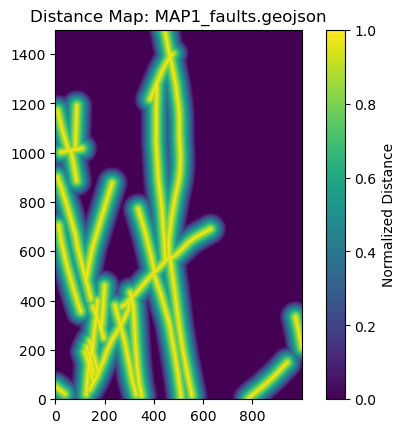

In [3]:
#PROCESS/PLOT FILES

grid_size = (1500, 1000)  # Example grid size, replace this with your actual grid size

# Prompt user to select files
geojson_files = select_geojson_files()

if geojson_files:
    # Popup window for the user to select between buffering or rasterizing
    buffer_lines = user_buffer_choice()

    buffer_distance_meters = 0  # Default no buffer

    if buffer_lines:
        # Ask the user for buffer distance if they chose to buffer the lines
        buffer_distance_meters = get_buffer_distance_meters()
        if buffer_distance_meters is None:
            print("Buffer distance input was invalid or canceled. Skipping buffering.")
            buffer_lines = False

    # Process files based on user's choice and buffer distance in meters
    raster_map = create_gridded_distance_map(geojson_files, grid_size, buffer_distance_meters=buffer_distance_meters)

    # Now, `raster_map` contains the 3D array with either distance maps or rasterized lines
    print("Generated map shape:", raster_map.shape)

    # Plotting the first layer to visualize the result
    plt.imshow(raster_map[0], cmap='viridis', origin='lower')
    plt.title(f"Distance Map: {os.path.basename(geojson_files[0])}")
    plt.colorbar(label='Normalized Distance')
    plt.show()
else:
    print("No files selected.")
